In [ ]:
!git clone https://github.com/daniltirsk/neural-astar

Cloning into 'neural-astar'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 218 (delta 20), reused 48 (delta 14), pack-reused 160
Receiving objects: 100% (218/218), 80.61 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
%cd ..

/content


In [ ]:
!rm -r neural-astar

In [ ]:
%cd neural-astar
!pip install .

/content/neural-astar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/neural-astar
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for neural-astar: filename=neural_astar-0.1.0-py3-none-any.whl size=11871 sha256=4a190318349e8b6895270a9b3345ac356bc5b84d9a9455c31f70176bea26a10d
  Stored in directory: /root/.cache/pip/wheels/e3/0e/7c/0f9c126ae8f463a446608b22e3e49c22d2c039444d6fa5f0e5
Successfully built neural-astar
  Attempting uninstall: neural-astar
    Found existing installation: neural-astar 0.1.0
    Uninstalling neural-astar-0.1.0:
      Successfully unin

In [ ]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.data import create_dataloader
from neural_astar.utils.training import set_global_seeds, calc_metrics_from_multiple_results, visualize_results

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import tensorflow as tf

In [ ]:
neural_astar_cnn = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar_cnn.load_state_dict(torch.load("/content/drive/MyDrive/tirskikh/best_cnn.pt", map_location=torch.device(device)))

neural_astar_unet = NeuralAstar(encoder_arch='Unet').to(device)
neural_astar_unet.load_state_dict(torch.load("/content/drive/MyDrive/tirskikh/best_unet.pt", map_location=torch.device(device)))

vanilla_astar = VanillaAstar().to(device)

In [ ]:
model_1 = tf.keras.models.load_model("/content/drive/MyDrive/tirskikh/a_star_heuristic_model_4_3")
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/tirskikh/a_star_heuristic_model_4")

In [ ]:
SHAPE = (64,64)

In [ ]:
!unzip "/content/drive/MyDrive/tirskikh/hard_dataset_4.zip"

Archive:  /content/drive/MyDrive/tirskikh/hard_dataset_4.zip
  inflating: annotations.csv         
  inflating: maps.npz                
  inflating: heuristics.npz          


In [ ]:
import pandas as pd
annot = pd.read_csv("./annotations.csv")

In [ ]:
heuristics = np.load("./heuristics.npz")

In [ ]:
maps_b = np.load("./maps.npz")

In [ ]:
DATASET_SIZE = 30000

In [ ]:
y = []
maps = []
starts = []
goals = []

cnt = 0

for name in annot['name']:
    data = annot.loc[annot['name'] == name]
    map = np.unpackbits(maps_b[name], count=SHAPE[0]*SHAPE[1]).reshape(SHAPE).view(bool)
    start = np.zeros(SHAPE)
    start[data['starty'],data['startx']] = 1
    goal = np.zeros(SHAPE, dtype="uint8")
    goal[data['goaly'],data['goalx']] = 1

    heuristic = heuristics[name]

    maps.append(map)
    starts.append(start)
    goals.append(goal)

    y.append(heuristic)

    cnt += 1
    if cnt%1000 == 0:
      print(cnt)
      break

1000


In [ ]:
y_pred = model_1(np.stack([np.stack(maps),goals],axis=3), training=False)
c1 = y_pred.numpy()
costs1 = np.stack(c1).reshape((-1,1,64,64)).astype(np.float32)
costs_1 = torch.Tensor(costs1).to(device)

In [ ]:
y_pred = model_2(np.stack([np.stack(maps),goals],axis=3), training=False)
c2 = y_pred.numpy()
costs2 = np.stack(c2).reshape((-1,1,64,64)).astype(np.float32)
costs_2 = torch.Tensor(costs2).to(device)

In [ ]:
test_maps = np.invert(np.stack(maps)).reshape((-1,1,64,64)).astype(np.float32)
test_goals = np.stack(goals).reshape((-1,1,64,64)).astype(np.float32)
test_starts = np.stack(starts).reshape((-1,1,64,64)).astype(np.float32)

In [ ]:
test_maps = torch.Tensor(test_maps).to(device)
test_goals = torch.Tensor(test_goals).to(device)
test_starts = torch.Tensor(test_starts).to(device)

In [ ]:
neural_astar_cnn.eval()
neural_astar_unet.eval()

na_cnn_outputs = []
na_unet_outputs = []
va_outputs = []
m1_outputs = []
m2_outputs = []

with torch.no_grad():
  for i in range(0,1000,100):
    print(i)
    na_cnn_outputs.append(neural_astar_cnn(test_maps[i:i+100], test_starts[i:i+100], test_goals[i:i+100]))
    na_unet_outputs.append(neural_astar_unet(test_maps[i:i+100], test_starts[i:i+100], test_goals[i:i+100]))
    va_outputs.append(vanilla_astar(test_maps[i:i+100], test_starts[i:i+100], test_goals[i:i+100]))
    m1_outputs.append(vanilla_astar(test_maps[i:i+100], test_starts[i:i+100], test_goals[i:i+100], cost_maps=costs_1[i:i+100]))
    m2_outputs.append(vanilla_astar(test_maps[i:i+100], test_starts[i:i+100], test_goals[i:i+100], cost_maps=costs_2[i:i+100]))

0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100
200
300
400
500
600
700
800
900


In [ ]:
neural_astar_cnn.eval()
neural_astar_unet.eval()

na_cnn_outputs = []
na_unet_outputs = []
va_outputs = []
m1_outputs = []
m2_outputs = []


s = 10
e = 15
with torch.no_grad():
  for i in range(s,e,100):
    print(i)
    na_cnn_outputs.append(neural_astar_cnn(test_maps[i:i+5], test_starts[i:i+5], test_goals[i:i+5]))
    na_unet_outputs.append(neural_astar_unet(test_maps[i:i+5], test_starts[i:i+5], test_goals[i:i+5]))
    va_outputs.append(vanilla_astar(test_maps[i:i+5], test_starts[i:i+5], test_goals[i:i+5]))
    m1_outputs.append(vanilla_astar(test_maps[i:i+5], test_starts[i:i+5], test_goals[i:i+5], cost_maps=costs_1[i:i+5]))
    m2_outputs.append(vanilla_astar(test_maps[i:i+5], test_starts[i:i+5], test_goals[i:i+5], cost_maps=costs_2[i:i+5]))

10


In [ ]:
calc_metrics_from_multiple_results(na_cnn_outputs, va_outputs)

optimality: 0.698, efficiency: 0.370, h_mean: 0.472

In [ ]:
calc_metrics_from_multiple_results(na_unet_outputs, va_outputs)

optimality: 0.760, efficiency: 0.342, h_mean: 0.464

In [ ]:
calc_metrics_from_multiple_results(m1_outputs, va_outputs)

optimality: 0.728, efficiency: 0.431, h_mean: 0.532

In [ ]:
calc_metrics_from_multiple_results(m2_outputs, va_outputs)

optimality: 0.673, efficiency: 0.430, h_mean: 0.516

In [ ]:
va_outputs[0].histories.shape

torch.Size([100, 1, 64, 64])

(-0.5, 331.5, 67.5, -0.5)

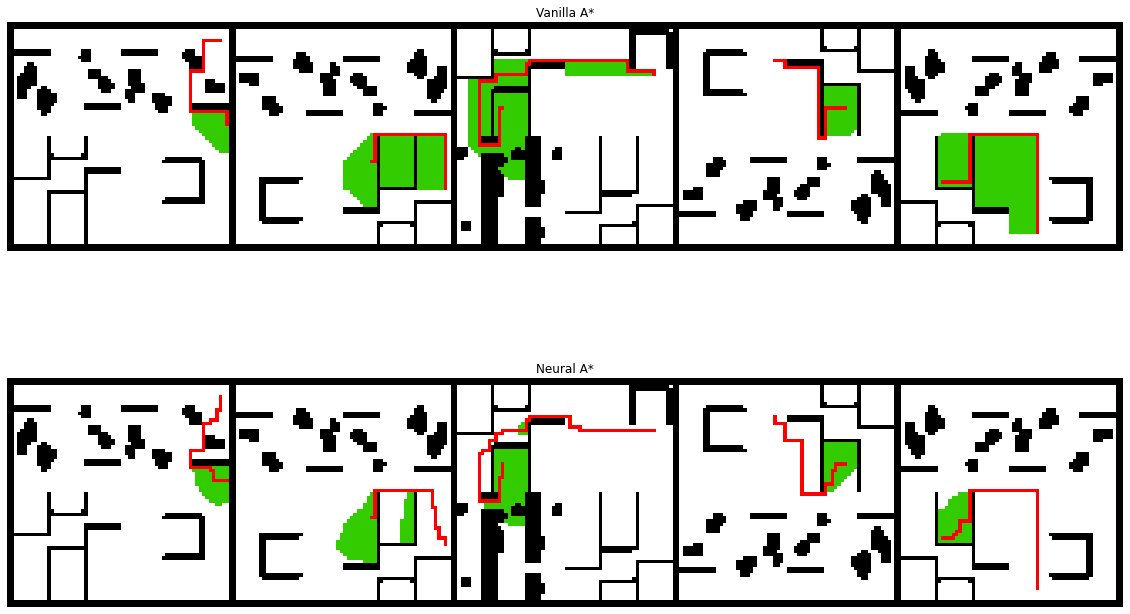

In [ ]:
plt.figure(figsize=[20, 12])
plt.subplot(2, 1, 1)
plt.imshow(visualize_results(test_maps[s:e].to('cpu'), va_outputs[0]))
plt.title("Vanilla A*")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(visualize_results(test_maps[s:e].to('cpu'), na_cnn_outputs[0]))
plt.title("Neural A*")
plt.axis("off")

(-0.5, 331.5, 67.5, -0.5)

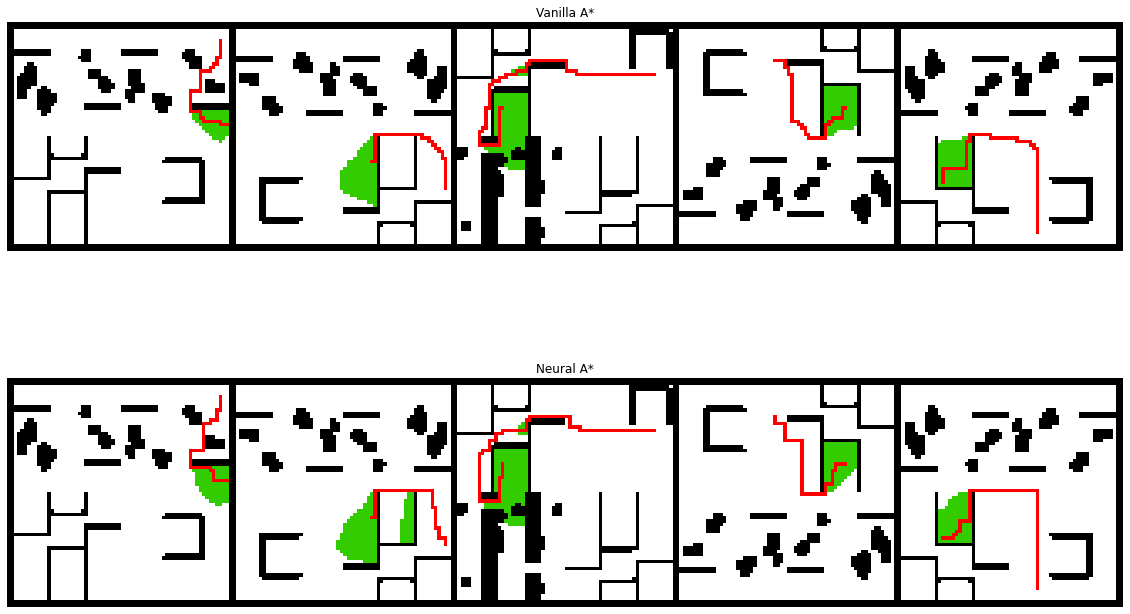

In [ ]:
plt.figure(figsize=[20, 12])
plt.subplot(2, 1, 1)
plt.imshow(visualize_results(test_maps[s:e].to('cpu'), na_unet_outputs[0]))
plt.title("Vanilla A*")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(visualize_results(test_maps[s:e].to('cpu'), na_cnn_outputs[0]))
plt.title("Neural A*")
plt.axis("off")